## Step 1.1: Import Core Libraries

In [1]:
# Step 1.1: Import Core Libraries
import os
import sys
import random
import math
from pathlib import Path
import time
import json
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

print("Python:", sys.version.splitlines()[0])
print("TensorFlow:", tf.__version__)

2025-11-13 09:44:14.602040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1763027054.823780      48 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1763027054.872822      48 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
TensorFlow: 2.18.0


## Step 1.2: Initialize GPU & Mixed Precision

In [2]:
# Step 1.2: Initialize GPU & Mixed Precision
gpus = tf.config.list_physical_devices('GPU')
print("GPUs found:", gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except Exception as e:
        print("Could not set memory growth:", e)

# Use mixed precision for speed (TF 2.18 supports it)
try:
    from tensorflow.keras import mixed_precision
    mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision policy:", mixed_precision.global_policy())
except Exception as e:
    print("Mixed precision not enabled:", e)

GPUs found: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Mixed precision policy: <DTypePolicy "mixed_float16">


## Step 2.1: Set Global Parameters

In [3]:
# Step 2.1: Global parameters (using the dataset paths you provided)
DATA_DIR = Path("/kaggle/input/mango-and-banana-rgb-image/Mango and Banana Dataset (Ripe Unripe)  Indian RGB image datasets for YOLO object detection/Mango_Banana_Dataset/data")
TRAIN_IMAGES = Path("/kaggle/input/mango-and-banana-rgb-image/Mango and Banana Dataset (Ripe Unripe)  Indian RGB image datasets for YOLO object detection/Mango_Banana_Dataset/data/train/images")
TRAIN_LABELS = Path("/kaggle/input/mango-and-banana-rgb-image/Mango and Banana Dataset (Ripe Unripe)  Indian RGB image datasets for YOLO object detection/Mango_Banana_Dataset/data/train/labels")
TEST_IMAGES = Path("/kaggle/input/mango-and-banana-rgb-image/Mango and Banana Dataset (Ripe Unripe)  Indian RGB image datasets for YOLO object detection/Mango_Banana_Dataset/data/test/images")
TEST_LABELS = Path("/kaggle/input/mango-and-banana-rgb-image/Mango and Banana Dataset (Ripe Unripe)  Indian RGB image datasets for YOLO object detection/Mango_Banana_Dataset/data/test/labels")

# Output and crop directories (working area)
OUTPUT_DIR = Path("/kaggle/working/classification_output")
CROPS_DIR = OUTPUT_DIR / "crops"
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)
CROPS_DIR.mkdir(parents=True, exist_ok=True)

# Model/training params tuned for P100
IMG_SIZE = 224         # start with 224 (EfficientNetB0). Increase for B3 (300).
BATCH_SIZE = 32        # adjust if OOM
AUTOTUNE = tf.data.AUTOTUNE
EPOCHS_PHASE1 = 6
EPOCHS_PHASE2 = 25
LR_PHASE1 = 1e-3
LR_PHASE2 = 1e-4
DROPOUT = 0.3
PAD_REL = 0.05         # crop padding relative to bbox size

print("DATA_DIR exists:", DATA_DIR.exists())
print("Train images found:", TRAIN_IMAGES.exists(), len(list(TRAIN_IMAGES.glob("*")) if TRAIN_IMAGES.exists() else []))
print("Train labels found:", TRAIN_LABELS.exists(), len(list(TRAIN_LABELS.glob("*.txt")) if TRAIN_LABELS.exists() else []))
print("Test images found:", TEST_IMAGES.exists(), len(list(TEST_IMAGES.glob("*")) if TEST_IMAGES.exists() else []))
print("Test labels found:", TEST_LABELS.exists(), len(list(TEST_LABELS.glob("*.txt")) if TEST_LABELS.exists() else []))

DATA_DIR exists: True
Train images found: True 3999
Train labels found: True 4000
Test images found: True 1000
Test labels found: True 1001


## Step 2.2: Sanity-check YOLO label files & infer classes

In [4]:
# Step 2.2: Inspect some label files to infer class ids
def list_txt(p):
    return sorted([f for f in Path(p).glob("*.txt")]) if p.exists() else []

train_label_files = list_txt(TRAIN_LABELS)
test_label_files = list_txt(TEST_LABELS)
print("Train label files:", len(train_label_files))
print("Test label files:", len(test_label_files))

# infer classes
class_ids = set()
sample_n = min(2000, len(train_label_files))
for lf in train_label_files[:sample_n]:
    text = lf.read_text().strip().splitlines()
    for line in text:
        parts = line.split()
        if len(parts) >= 5:
            try:
                cid = int(float(parts[0]))
                class_ids.add(cid)
            except:
                pass
class_ids = sorted(class_ids)
print("Inferred class ids:", class_ids)

# Suggested mapping (dataset description implies 4 classes). If ids are 0..3 we'll map:
default_names = ["mango_ripe", "mango_unripe", "banana_ripe", "banana_unripe"]
if len(class_ids) == len(default_names) and class_ids == list(range(len(default_names))):
    CLASS_MAP = {i: default_names[i] for i in class_ids}
else:
    # fallback - map in increasing order to default names where possible
    CLASS_MAP = {cid: (default_names[i] if i < len(default_names) else f"class_{cid}") for i,cid in enumerate(class_ids)}
print("CLASS_MAP (id -> name):", CLASS_MAP)
NUM_CLASSES = len(CLASS_MAP)

Train label files: 4000
Test label files: 1001
Inferred class ids: [0, 1, 2]
CLASS_MAP (id -> name): {0: 'mango_ripe', 1: 'mango_unripe', 2: 'banana_ripe'}


## Step 3.1: Convert YOLO annotations into cropped images

In [5]:
# Step 3.1: Functions to convert normalized yolo bbox to pixel bbox and save crops
def yolo_to_bbox(vals, img_w, img_h):
    x_center, y_center, w, h = map(float, vals)
    x1 = int(max(0, (x_center - w/2) * img_w))
    y1 = int(max(0, (y_center - h/2) * img_h))
    x2 = int(min(img_w, (x_center + w/2) * img_w))
    y2 = int(min(img_h, (y_center + h/2) * img_h))
    return x1, y1, x2, y2

def save_crops(images_dir, labels_dir, split_name="train"):
    saved = 0
    images = sorted([p for p in Path(images_dir).glob("*")])
    for img_path in images:
        lab_path = Path(labels_dir) / (img_path.stem + ".txt")
        if not lab_path.exists():
            continue
        try:
            img = Image.open(img_path).convert("RGB")
        except Exception as e:
            print("Could not open:", img_path, e)
            continue
        w,h = img.size
        lines = lab_path.read_text().strip().splitlines()
        for i, line in enumerate(lines):
            parts = line.split()
            if len(parts) < 5:
                continue
            cid = int(float(parts[0])); coords = parts[1:5]
            x1,y1,x2,y2 = yolo_to_bbox(coords, w, h)
            # pad
            pad_w = int((x2-x1) * PAD_REL)
            pad_h = int((y2-y1) * PAD_REL)
            x1p = max(0, x1 - pad_w); y1p = max(0, y1 - pad_h)
            x2p = min(w, x2 + pad_w); y2p = min(h, y2 + pad_h)
            if (x2p - x1p) < 16 or (y2p - y1p) < 16:
                continue
            cname = CLASS_MAP.get(cid, f"class_{cid}")
            out_dir = CROPS_DIR / split_name / cname
            out_dir.mkdir(parents=True, exist_ok=True)
            out_name = out_dir / f"{img_path.stem}_{i}.jpg"
            try:
                crop = img.crop((x1p, y1p, x2p, y2p))
                crop.save(out_name, quality=90)
                saved += 1
            except Exception as e:
                print("Save error:", out_name, e)
    return saved

print("Cropping train images...")
saved_train = save_crops(TRAIN_IMAGES, TRAIN_LABELS, split_name="train")
print("Saved train crops:", saved_train)
print("Cropping test images...")
saved_test = save_crops(TEST_IMAGES, TEST_LABELS, split_name="test")
print("Saved test crops:", saved_test)

Cropping train images...
Saved train crops: 6775
Cropping test images...
Saved test crops: 1321


## Step 3.2: Inspect crop counts & examples

Train crop count: 6775
Test crop count: 1321


label
class_3         2043
mango_ripe      1685
mango_unripe    1533
banana_ripe     1514
Name: count, dtype: int64

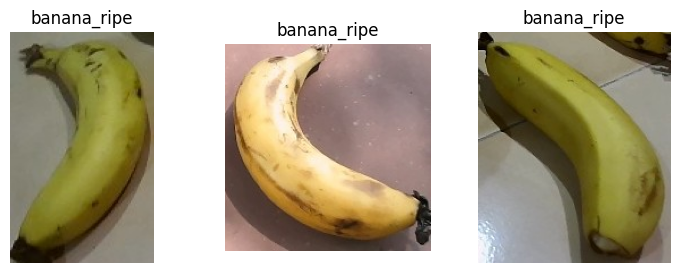

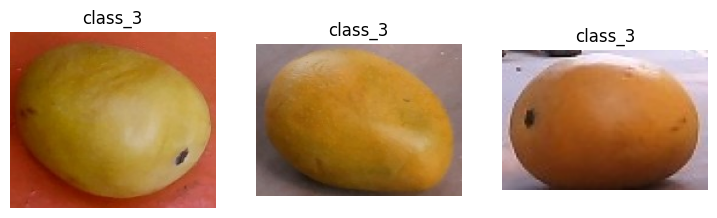

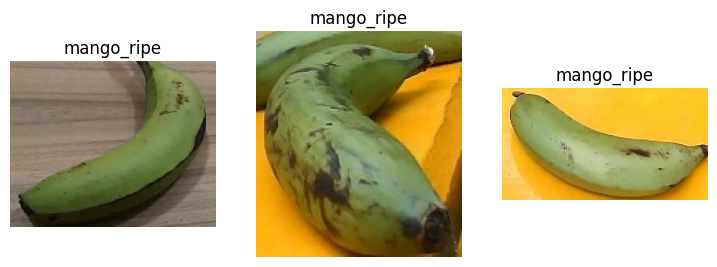

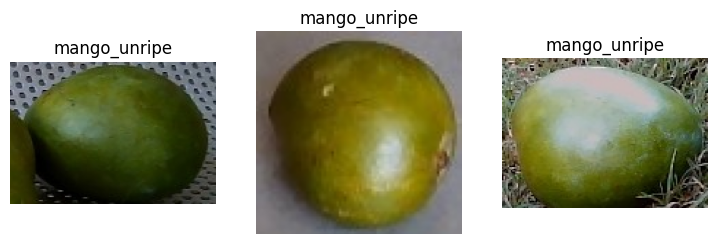

In [6]:
# Step 3.2: Count crops per class and display a few examples
def build_crops_df(split="train"):
    rows=[]
    base = CROPS_DIR / split
    if not base.exists():
        return pd.DataFrame(columns=["filepath","label"])
    for cls_dir in sorted([p for p in base.iterdir() if p.is_dir()]):
        for f in cls_dir.glob("*"):
            rows.append({"filepath": str(f), "label": cls_dir.name})
    return pd.DataFrame(rows)

df_train_crops = build_crops_df("train")
df_test_crops = build_crops_df("test")
print("Train crop count:", len(df_train_crops))
print("Test crop count:", len(df_test_crops))
if len(df_train_crops) > 0:
    display(df_train_crops['label'].value_counts())
    # show 3 examples per class
    for c in sorted(df_train_crops['label'].unique()):
        sample = list((CROPS_DIR/"train"/c).glob("*"))[:3]
        if not sample:
            continue
        fig, axs = plt.subplots(1, len(sample), figsize=(len(sample)*3,3))
        for ax, p in zip(axs, sample):
            ax.imshow(Image.open(p))
            ax.set_title(c)
            ax.axis('off')
        plt.show()

## Step 4.1: Create train/val/test splits from crops

In [7]:
# Step 4.1: Build DataFrames + stratified train/val split. Test is the separate set we created.
if len(df_train_crops) == 0:
    raise RuntimeError("No train crops found. Check earlier cropping step.")
train_df, val_df = train_test_split(df_train_crops, test_size=0.15, stratify=df_train_crops['label'], random_state=SEED)
print("Train rows:", len(train_df), "Val rows:", len(val_df), "Test rows:", len(df_test_crops))
# Save CSVs for reproducibility
(train_df).to_csv(OUTPUT_DIR/"train_df.csv", index=False)
(val_df).to_csv(OUTPUT_DIR/"val_df.csv", index=False)
(df_test_crops).to_csv(OUTPUT_DIR/"test_df.csv", index=False)

Train rows: 5758 Val rows: 1017 Test rows: 1321


## Step 5.1: Build tf.data pipelines

In [8]:
# Step 5.1: tf.data pipeline functions with augmentation
label_list = sorted(train_df['label'].unique())
CLASS_TO_IDX = {c:i for i,c in enumerate(label_list)}
IDX_TO_CLASS = {i:c for c,i in CLASS_TO_IDX.items()}
NUM_CLASSES = len(label_list)
print("Classes:", CLASS_TO_IDX)

def read_and_preprocess(path, label, img_size=IMG_SIZE):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [img_size, img_size])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

# Keras augmentation (fast, GPU-friendly)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.07),
    layers.RandomZoom(0.07),
    layers.RandomTranslation(0.04, 0.04),
    layers.RandomContrast(0.06),
], name="data_augmentation")

def df_to_dataset(df, shuffle=False, augment=False, batch_size=BATCH_SIZE):
    paths = df['filepath'].values
    labels = [CLASS_TO_IDX[l] for l in df['label'].values]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED)
    ds = ds.map(lambda p,l: (read_and_preprocess(p,l)), num_parallel_calls=AUTOTUNE)
    if augment:
        ds = ds.map(lambda x,y: (data_augmentation(x, training=True), tf.one_hot(y, NUM_CLASSES, dtype=tf.float32)), num_parallel_calls=AUTOTUNE)
    else:
        ds = ds.map(lambda x,y: (x, tf.one_hot(y, NUM_CLASSES, dtype=tf.float32)), num_parallel_calls=AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(AUTOTUNE)
    return ds

train_ds = df_to_dataset(train_df, shuffle=True, augment=True)
val_ds = df_to_dataset(val_df, shuffle=False, augment=False)
test_ds = df_to_dataset(df_test_crops, shuffle=False, augment=False)

# sanity check
for imgs, labels in train_ds.take(1):
    print("Batch shapes:", imgs.shape, labels.shape)

Classes: {'banana_ripe': 0, 'class_3': 1, 'mango_ripe': 2, 'mango_unripe': 3}


I0000 00:00:1763027131.250417      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Batch shapes: (32, 224, 224, 3) (32, 4)


## Step 5.2: Compute class weights

In [9]:
# Step 5.2: Compute class weights (helpful if imbalance)
train_counts = Counter(train_df['label'].values)
total = sum(train_counts.values())
class_weight = {CLASS_TO_IDX[c]: total/(NUM_CLASSES * cnt) for c,cnt in train_counts.items()}
print("Class weights:", class_weight)

Class weights: {0: 1.1184926184926185, 1: 0.8292050691244239, 3: 1.104758250191865, 2: 1.0052374301675977}


## Step 6.1: Model factory - EfficientNet

In [10]:
# Step 6.1: Build EfficientNet model factory (final activation float32 for safety)
def build_model(backbone="EfficientNetB0", img_size=IMG_SIZE, n_classes=NUM_CLASSES, dropout=DROPOUT):
    inputs = layers.Input(shape=(img_size, img_size, 3), name="image_input")
    x = inputs  # pipeline already scales to [0,1]
    backbone_lower = backbone.lower()
    if backbone_lower == "efficientnetb0":
        base = tf.keras.applications.EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
    elif backbone_lower == "efficientnetb3":
        base = tf.keras.applications.EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")
    elif backbone_lower == "resnet50":
        base = tf.keras.applications.ResNet50(include_top=False, input_tensor=x, weights="imagenet")
    else:
        raise ValueError("Unsupported backbone")
    y = base.output
    y = layers.GlobalAveragePooling2D(name="gap")(y)
    y = layers.Dropout(dropout, name="dropout")(y)
    y = layers.Dense(n_classes, name="logits")(y)
    outputs = layers.Activation("softmax", dtype="float32", name="predictions")(y)
    model = keras.Model(inputs=inputs, outputs=outputs, name=f"classifier_{backbone}")
    return model

# quick build check
model = build_model("EfficientNetB0")
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "classifier_EfficientNetB0"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast (Cast)         │ (None, 224, 224,  │          0 │ image_input[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ cast[0][0]        │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

## Step 6.2: Callbacks & compile

In [11]:
# Step 6.2: Callbacks and compilation utility
def get_callbacks(name="run"):
    cbs = [
        keras.callbacks.ModelCheckpoint(str(OUTPUT_DIR/f"{name}_best.h5"), save_best_only=True, monitor="val_loss", mode="min"),
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-7)
    ]
    return cbs

def compile_model(m, lr=1e-3, weight_decay=1e-5):
    # use AdamW if available in this TF version, else Adam
    try:
        opt = tf.keras.optimizers.experimental.AdamW(learning_rate=lr, weight_decay=weight_decay)
    except Exception:
        opt = tf.keras.optimizers.Adam(learning_rate=lr)
    m.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
    return m

## Step 7.1: Two-phase training function

In [12]:
# Step 7.1: Two-phase training (head then fine-tune)
def train_two_phase(backbone="EfficientNetB0", epochs1=EPOCHS_PHASE1, epochs2=EPOCHS_PHASE2, lr1=LR_PHASE1, lr2=LR_PHASE2, unfreeze_all=False):
    model = build_model(backbone)
    # Phase 1: freeze base
    for layer in model.layers:
        if hasattr(layer, "trainable"):
            layer.trainable = False
    # make top layers trainable (head)
    for layer in model.layers[-20:]:
        layer.trainable = True
    compile_model(model, lr=lr1)
    print("Phase 1: training head only")
    h1 = model.fit(train_ds, validation_data=val_ds, epochs=epochs1, callbacks=get_callbacks(backbone+"_phase1"), class_weight=class_weight, verbose=2)
    # Phase 2: unfreeze
    if unfreeze_all:
        for layer in model.layers:
            if "batch_normalization" in layer.name:
                layer.trainable = False
            else:
                layer.trainable = True
    else:
        # unfreeze last block
        for layer in model.layers[-120:]:
            if "batch_normalization" in layer.name:
                layer.trainable = False
            else:
                layer.trainable = True
    compile_model(model, lr=lr2)
    print("Phase 2: fine-tuning")
    h2 = model.fit(train_ds, validation_data=val_ds, epochs=epochs2, callbacks=get_callbacks(backbone+"_phase2"), class_weight=class_weight, verbose=2)
    return model, h1, h2

## Step 8.1: Run training

In [13]:
# Step 8.1: Run a quick smoke test (1 epoch) before full training to ensure loop works
print("Running quick smoke test (1 epoch) to validate pipeline ...")
smoke_model = build_model("EfficientNetB0")
compile_model(smoke_model, lr=LR_PHASE1)
smoke_model.fit(train_ds.take(50), validation_data=val_ds.take(10), epochs=1, verbose=2)  # very small run

# If smoke test OK, run full two-phase training
print("Starting full two-phase training (EfficientNetB0) ...")
start = time.time()
model_b0, hist1_b0, hist2_b0 = train_two_phase("EfficientNetB0", epochs1=EPOCHS_PHASE1, epochs2=EPOCHS_PHASE2, unfreeze_all=False)
elapsed = (time.time() - start) / 60
print(f"Training finished in {elapsed:.2f} minutes")

Running quick smoke test (1 epoch) to validate pipeline ...


I0000 00:00:1763027174.448303     111 service.cc:148] XLA service 0x7dc5d4002970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1763027174.449223     111 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1763027181.260508     111 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1763027218.883445     111 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 - 102s - 2s/step - accuracy: 0.8763 - loss: 0.3127 - val_accuracy: 0.2344 - val_loss: 1.7279
Starting full two-phase training (EfficientNetB0) ...
Phase 1: training head only
Epoch 1/6


180/180 - 98s - 543ms/step - accuracy: 0.2734 - loss: 1.4261 - val_accuracy: 0.2262 - val_loss: 1.5946 - learning_rate: 0.0010
Epoch 2/6
180/180 - 49s - 275ms/step - accuracy: 0.3748 - loss: 1.2852 - val_accuracy: 0.2262 - val_loss: 2.3419 - learning_rate: 0.0010
Epoch 3/6


180/180 - 50s - 278ms/step - accuracy: 0.4316 - loss: 1.1690 - val_accuracy: 0.4798 - val_loss: 1.1053 - learning_rate: 0.0010
Epoch 4/6
180/180 - 49s - 273ms/step - accuracy: 0.4614 - loss: 1.1524 - val_accuracy: 0.3019 - val_loss: 4.6550 - learning_rate: 0.0010
Epoch 5/6
180/180 - 50s - 278ms/step - accuracy: 0.4738 - loss: 1.1015 - val_accuracy: 0.3019 - val_loss: 4.9867 - learning_rate: 0.0010
Epoch 6/6
180/180 - 81s - 451ms/step - accuracy: 0.5002 - loss: 1.0701 - val_accuracy: 0.4730 - val_loss: 1.1211 - learning_rate: 0.0010
Phase 2: fine-tuning
Epoch 1/25


180/180 - 129s - 716ms/step - accuracy: 0.5505 - loss: 0.9871 - val_accuracy: 0.3019 - val_loss: 1.6149 - learning_rate: 1.0000e-04
Epoch 2/25


180/180 - 51s - 286ms/step - accuracy: 0.6949 - loss: 0.6805 - val_accuracy: 0.5172 - val_loss: 1.3557 - learning_rate: 1.0000e-04
Epoch 3/25


180/180 - 52s - 287ms/step - accuracy: 0.7395 - loss: 0.5640 - val_accuracy: 0.6323 - val_loss: 0.9140 - learning_rate: 1.0000e-04
Epoch 4/25
180/180 - 51s - 283ms/step - accuracy: 0.7490 - loss: 0.5411 - val_accuracy: 0.6047 - val_loss: 1.0939 - learning_rate: 1.0000e-04
Epoch 5/25
180/180 - 51s - 283ms/step - accuracy: 0.7807 - loss: 0.4957 - val_accuracy: 0.5782 - val_loss: 0.9672 - learning_rate: 1.0000e-04
Epoch 6/25
180/180 - 51s - 283ms/step - accuracy: 0.8020 - loss: 0.4547 - val_accuracy: 0.6824 - val_loss: 0.9789 - learning_rate: 1.0000e-04
Epoch 7/25
180/180 - 82s - 455ms/step - accuracy: 0.8314 - loss: 0.4020 - val_accuracy: 0.5959 - val_loss: 1.1909 - learning_rate: 5.0000e-05
Epoch 8/25


180/180 - 52s - 287ms/step - accuracy: 0.8265 - loss: 0.4001 - val_accuracy: 0.8427 - val_loss: 0.3870 - learning_rate: 5.0000e-05
Epoch 9/25
180/180 - 51s - 284ms/step - accuracy: 0.8355 - loss: 0.3804 - val_accuracy: 0.7316 - val_loss: 0.7729 - learning_rate: 5.0000e-05
Epoch 10/25
180/180 - 51s - 284ms/step - accuracy: 0.8548 - loss: 0.3473 - val_accuracy: 0.7286 - val_loss: 0.7196 - learning_rate: 5.0000e-05
Epoch 11/25
180/180 - 82s - 458ms/step - accuracy: 0.8559 - loss: 0.3407 - val_accuracy: 0.6067 - val_loss: 1.3097 - learning_rate: 5.0000e-05
Epoch 12/25
180/180 - 52s - 287ms/step - accuracy: 0.8757 - loss: 0.3093 - val_accuracy: 0.8181 - val_loss: 0.4719 - learning_rate: 2.5000e-05
Epoch 13/25
180/180 - 51s - 284ms/step - accuracy: 0.8741 - loss: 0.3020 - val_accuracy: 0.7758 - val_loss: 0.6317 - learning_rate: 2.5000e-05
Epoch 14/25
180/180 - 51s - 284ms/step - accuracy: 0.8887 - loss: 0.2745 - val_accuracy: 0.8004 - val_loss: 0.4763 - learning_rate: 2.5000e-05
Epoch 15/25


## Step 9.1: Evaluate on test set & classification report

In [15]:
# Option A: load H5 with custom_objects mapping for Cast
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Create a simple Cast layer replacement that casts to float32 (name must match 'Cast')
class CastLayer(layers.Layer):
    def __init__(self, dtype='float32', **kwargs):
        super().__init__(**kwargs)
        self._target_dtype = tf.as_dtype(dtype)

    def call(self, inputs):
        return tf.cast(inputs, self._target_dtype)

    def get_config(self):
        # ensure serialization compatibility
        cfg = super().get_config()
        cfg.update({"dtype": self._target_dtype.name})
        return cfg

# Try loading model with custom_objects
best_ckpt = next(OUTPUT_DIR.glob("*_phase2_best.h5"), None)
if best_ckpt and best_ckpt.exists():
    try:
        print("Loading with custom CastLayer mapping:", best_ckpt)
        final_model = keras.models.load_model(best_ckpt, custom_objects={"Cast": CastLayer, "CastLayer": CastLayer})
        print("Loaded model successfully.")
    except Exception as e:
        print("Loading with CastLayer mapping failed:", repr(e))
        final_model = None
else:
    final_model = None
    print("No best checkpoint found; using in-memory model object if available.")

# If loaded, compile (or recompile) before evaluation
if final_model is not None:
    # Recompile with same optimizer settings (optional)
    try:
        # If you used AdamW earlier, prefer the same; fallback to Adam
        try:
            opt = tf.keras.optimizers.experimental.AdamW(learning_rate=LR_PHASE2, weight_decay=1e-5)
        except Exception:
            opt = tf.keras.optimizers.Adam(learning_rate=LR_PHASE2)
        final_model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])
        print("Compiled loaded model.")
    except Exception as e:
        print("Could not compile model:", e)
else:
    print("final_model is None — will fallback to in-memory model if available (model_b0).")

Loading with custom CastLayer mapping: /kaggle/working/classification_output/EfficientNetB0_phase2_best.h5


Loaded model successfully.
Compiled loaded model.


In [16]:
# Evaluate on test set if final_model loaded
if final_model is not None:
    loss, acc = final_model.evaluate(test_ds, verbose=1)
    print(f"Test loss: {loss:.4f}, Test acc: {acc:.4f}")
else:
    print("No final_model loaded; using fallback model_b0 if present.")
    try:
        loss, acc = model_b0.evaluate(test_ds, verbose=1)
        print(f"Fallback model_b0 -> Test loss: {loss:.4f}, Test acc: {acc:.4f}")
        final_model = model_b0
    except Exception as e:
        print("Fallback evaluation failed:", e)

42/42 ━━━━━━━━━━━━━━━━━━━━ 13s 131ms/step - accuracy: 0.6909 - loss: 0.5623
Test loss: 0.3195, Test acc: 0.8441


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━

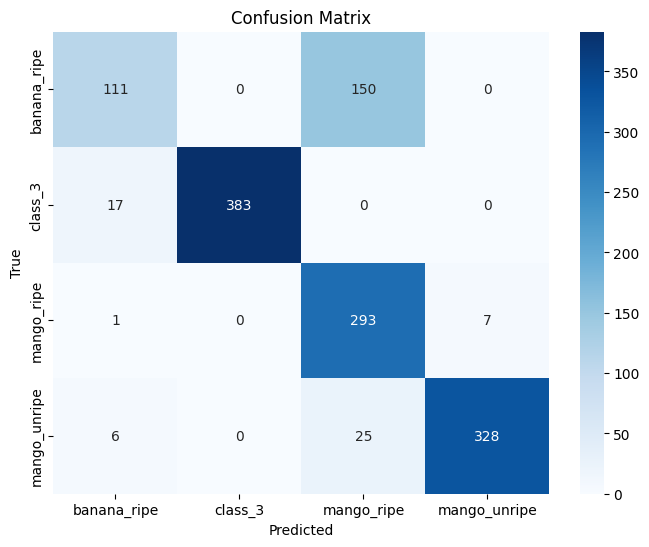

In [17]:
# Classification report & confusion matrix
if final_model is not None:
    y_true = []
    y_pred = []
    for imgs, labels in test_ds:
        preds = final_model.predict(imgs)
        y_true.extend(np.argmax(labels.numpy(), axis=1).tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())

    print("\nClassification Report:")
    from sklearn.metrics import classification_report, confusion_matrix
    print(classification_report(y_true, y_pred, target_names=label_list, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    import matplotlib.pyplot as plt, seaborn as sns
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=label_list, yticklabels=label_list, cmap="Blues")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
    plt.show()
else:
    print("No final_model available to evaluate.")

Saved plot to: /kaggle/working/classification_output/training_curves_b0.png


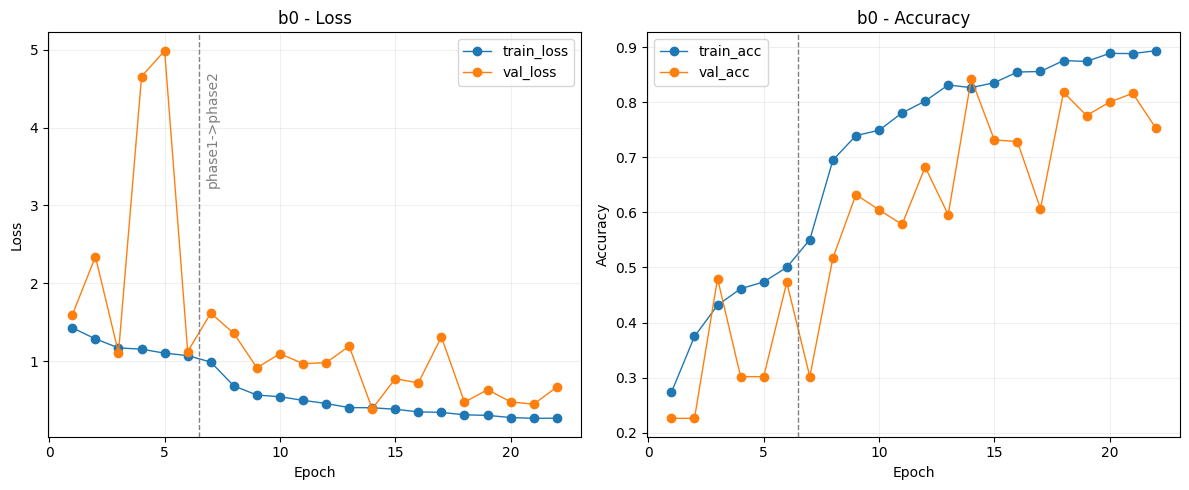

In [18]:
# Step 12: Plot Train/Val Curves
# This cell will automatically find training histories from common variable names
# (e.g., hist1_b0 / hist2_b0, history objects returned by model.fit, or a `histories` dict).
# It combines phase-1 and phase-2 histories (if present) and plots loss & accuracy.

import matplotlib.pyplot as plt
import math
import os

def _extract_history_parts(h):
    """Return dict with lists for loss/val_loss/accuracy/val_accuracy if available."""
    d = {}
    hist = getattr(h, "history", h)  # accept either History object or raw dict
    # common keys
    d['loss'] = list(hist.get('loss', []))
    d['val_loss'] = list(hist.get('val_loss', []))
    # accuracy key variants
    acc = hist.get('accuracy') or hist.get('acc') or hist.get('categorical_accuracy') or hist.get('auc')
    val_acc = hist.get('val_accuracy') or hist.get('val_acc') or hist.get('val_categorical_accuracy') or hist.get('val_auc')
    d['accuracy'] = list(acc) if acc is not None else []
    d['val_accuracy'] = list(val_acc) if val_acc is not None else []
    return d

def find_histories_from_globals(g):
    """Search globals for typical history variables and return list of (phase1, phase2) tuples or combined dicts."""
    found = {}
    # if a `histories` dict exists (from earlier multi-backbone runs)
    if 'histories' in g and isinstance(g['histories'], dict):
        return g['histories']  # assume user has histories[backbone] = (h1.history, h2.history)
    # search for names like hist1_*, hist2_*, h1_*, h2_*
    h1_candidates = {k: v for k,v in g.items() if (k.startswith('hist1_') or k.startswith('h1_') or k.startswith('history1_'))}
    h2_candidates = {k: v for k,v in g.items() if (k.startswith('hist2_') or k.startswith('h2_') or k.startswith('history2_'))}
    # pair by suffix if possible
    paired = {}
    for k1 in h1_candidates:
        suffix = k1.split('_',1)[-1]
        k2 = None
        for cand in h2_candidates:
            if cand.split('_',1)[-1] == suffix:
                k2 = cand
                break
        paired[suffix] = (h1_candidates[k1], h2_candidates.get(k2))  # h2 may be None
    # also if single-phase histories present like hist_b0 or history_b0
    single_histories = {k:v for k,v in g.items() if (k.startswith('hist_') or k.startswith('history_') or k.startswith('h_')) and not k.endswith('_bck')}
    # merge
    result = {}
    for s,(h1,h2) in paired.items():
        result[s] = (h1, h2)
    for k,v in single_histories.items():
        if k not in result:
            result[k] = (v, None)
    # fallback: if hist1_b0 and hist2_b0 exist (common names), keep them under key 'model'
    if not result:
        if 'hist1_b0' in g or 'hist2_b0' in g:
            result['effnetb0'] = (g.get('hist1_b0'), g.get('hist2_b0'))
        elif 'h1_b0' in g or 'h2_b0' in g:
            result['effnetb0'] = (g.get('h1_b0'), g.get('h2_b0'))
        elif 'hist' in g:
            result['hist'] = (g.get('hist'), None)
    return result

# locate histories
globals_dict = globals()
found_histories = find_histories_from_globals(globals_dict)

if not found_histories:
    print("No training histories found in globals().\n"
          "Make sure you have variables like `hist1_b0`, `hist2_b0` (History objects) or a `histories` dict.\n"
          "If you just finished training and have `h1` and `h2` variables, assign them to globals as e.g. `hist1_b0 = h1` and `hist2_b0 = h2`, then re-run this cell.")
else:
    # iterate and plot each found key
    for key, (h1, h2) in found_histories.items():
        # convert to dict parts
        parts1 = _extract_history_parts(h1) if h1 is not None else {'loss':[],'val_loss':[],'accuracy':[],'val_accuracy':[]}
        parts2 = _extract_history_parts(h2) if h2 is not None else {'loss':[],'val_loss':[],'accuracy':[],'val_accuracy':[]}
        train_loss = parts1['loss'] + parts2['loss']
        val_loss = parts1['val_loss'] + parts2['val_loss']
        train_acc = parts1['accuracy'] + parts2['accuracy']
        val_acc = parts1['val_accuracy'] + parts2['val_accuracy']
        n_epochs = max(len(train_loss), len(val_loss), len(train_acc), len(val_acc))
        epochs = list(range(1, n_epochs+1))
        phase1_len = len(parts1['loss'])
        plt.figure(figsize=(12,5))
        # Loss subplot
        plt.subplot(1,2,1)
        if train_loss:
            plt.plot(epochs[:len(train_loss)], train_loss, label='train_loss', marker='o', linewidth=1)
        if val_loss:
            plt.plot(epochs[:len(val_loss)], val_loss, label='val_loss', marker='o', linewidth=1)
        if phase1_len:
            plt.axvline(x=phase1_len + 0.5, color='gray', linestyle='--', linewidth=1)
            plt.text(phase1_len + 0.8, max(max(train_loss) if train_loss else 0, max(val_loss) if val_loss else 0)*0.95,
                     'phase1->phase2', rotation=90, va='top', color='gray')
        plt.title(f"{key} - Loss")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.legend()
        plt.grid(alpha=0.2)

        # Accuracy subplot
        plt.subplot(1,2,2)
        if train_acc:
            plt.plot(epochs[:len(train_acc)], train_acc, label='train_acc', marker='o', linewidth=1)
        if val_acc:
            plt.plot(epochs[:len(val_acc)], val_acc, label='val_acc', marker='o', linewidth=1)
        if phase1_len:
            plt.axvline(x=phase1_len + 0.5, color='gray', linestyle='--', linewidth=1)
        plt.title(f"{key} - Accuracy")
        plt.xlabel("Epoch")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.grid(alpha=0.2)

        plt.tight_layout()
        # save figure
        out_path = OUTPUT_DIR / f"training_curves_{key}.png"
        try:
            plt.savefig(out_path, dpi=150)
            print(f"Saved plot to: {out_path}")
        except Exception as e:
            print("Could not save plot:", e)
        plt.show()

## Step 10.1: Save final model & artifacts

In [22]:
# Save model robustly (corrected for Keras 3 rules)
from pathlib import Path
import traceback, json

OUTPUT_DIR = Path("/kaggle/working/classification_output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# choose model object
model_obj = globals().get('final_model') or globals().get('model_b0') or None
if model_obj is None:
    raise RuntimeError("No model object found in session (final_model or model_b0).")

results = {}
try:
    # 1) Native Keras .keras format (recommended)
    p_keras = OUTPUT_DIR / "final_effnetb0.keras"
    try:
        model_obj.save(p_keras, include_optimizer=False)   # recommended
        results['keras'] = str(p_keras)
        print("Saved model in native Keras format:", p_keras)
    except Exception as e:
        results['keras_error'] = repr(e)
        print("Failed to save .keras:", e)
        traceback.print_exc()

    # 2) TensorFlow SavedModel (directory). No save_format arg in Keras 3.
    p_saved = OUTPUT_DIR / "final_effnetb0_savedmodel"
    try:
        model_obj.save(p_saved, include_optimizer=False)   # directory -> SavedModel
        results['savedmodel'] = str(p_saved)
        print("Saved model as TensorFlow SavedModel directory:", p_saved)
    except Exception as e:
        results['savedmodel_error'] = repr(e)
        print("Failed to save SavedModel:", e)
        traceback.print_exc()

    # 3) Weights-only with correct suffix ".weights.h5"
    p_weights = OUTPUT_DIR / "final_effnetb0.weights.h5"
    try:
        model_obj.save_weights(p_weights)
        results['weights_h5'] = str(p_weights)
        print("Saved weights-only (HDF5):", p_weights)
    except Exception as e:
        results['weights_h5_error'] = repr(e)
        print("Failed to save weights-only (.weights.h5):", e)
        traceback.print_exc()

except Exception as e:
    print("Unexpected error while saving model:", repr(e))
    traceback.print_exc()

# Print summary JSON
print("\nSave results summary:")
print(json.dumps(results, indent=2))

# Quick how-to reload
print("\nHow to reload:")
print(f"  - Native Keras: model = keras.models.load_model('{results.get('keras')}')")
print(f"  - SavedModel:   model = keras.models.load_model('{results.get('savedmodel')}')")
print("  - Weights-only: rebuilt = build_model(...); rebuilt.load_weights('<path>.weights.h5')")

Saved model in native Keras format: /kaggle/working/classification_output/final_effnetb0.keras
Failed to save SavedModel: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/kaggle/working/classification_output/final_effnetb0_savedmodel.


Traceback (most recent call last):
  File "/tmp/ipykernel_48/856989215.py", line 29, in <cell line: 0>
    model_obj.save(p_saved, include_optimizer=False)   # directory -> SavedModel
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_api.py", line 114, in save_model
    raise ValueError(
ValueError: Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/kaggle/working/classification_output/final_effnetb0_savedmodel.


Saved weights-only (HDF5): /kaggle/working/classification_output/final_effnetb0.weights.h5

Save results summary:
{
  "keras": "/kaggle/working/classification_output/final_effnetb0.keras",
  "savedmodel_error": "ValueError('Invalid filepath extension for saving. Please add either a `.keras` extension for the native Keras format (recommended) or a `.h5` extension. Use `model.export(filepath)` if you want to export a SavedModel for use with TFLite/TFServing/etc. Received: filepath=/kaggle/working/classification_output/final_effnetb0_savedmodel.')",
  "weights_h5": "/kaggle/working/classification_output/final_effnetb0.weights.h5"
}

How to reload:
  - Native Keras: model = keras.models.load_model('/kaggle/working/classification_output/final_effnetb0.keras')
  - SavedModel:   model = keras.models.load_model('None')
  - Weights-only: rebuilt = build_model(...); rebuilt.load_weights('<path>.weights.h5')


In [23]:
# Cell: Save class mapping and CSVs (safe, independent of model save)
import json
from pathlib import Path

OUTPUT_DIR = Path("/kaggle/working/classification_output")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Ensure these variables exist in your session; if not, adjust names
mapping = {}
if 'CLASS_TO_IDX' in globals():
    mapping['CLASS_TO_IDX'] = CLASS_TO_IDX
if 'IDX_TO_CLASS' in globals():
    mapping['IDX_TO_CLASS'] = IDX_TO_CLASS
if 'CLASS_MAP' in globals():
    mapping['CLASS_MAP'] = CLASS_MAP

with open(OUTPUT_DIR / "class_mapping.json", "w") as f:
    json.dump(mapping, f, indent=2)
print("Saved class_mapping.json")

# Save CSVs if present
for name in ['train_df','val_df','df_test_crops']:
    if name in globals():
        df = globals()[name]
        out = OUTPUT_DIR / f"{name}.csv"
        df.to_csv(out, index=False)
        print("Saved", out)
print("All artifacts saved to:", OUTPUT_DIR)

Saved class_mapping.json
Saved /kaggle/working/classification_output/train_df.csv
Saved /kaggle/working/classification_output/val_df.csv
Saved /kaggle/working/classification_output/df_test_crops.csv
All artifacts saved to: /kaggle/working/classification_output
